# Machine Translation + Transformer

<img src = "../figures/transformer1.png" >

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, random_split, Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch.optim as optim
import math, time
from datasets import load_dataset

device = torch.device('cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 0
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\surya\anaconda3\envs\venv_nlp\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\surya\anaconda3\envs\venv_nlp\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "c:\Users\surya\anaconda3\envs\venv_nlp\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\surya\anaconda3\envs\venv_nlp\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    a

cpu


## 1. ETL: Loading the dataset

**Note**: Here I chose to translate English to German, simply it is easier for myself, since I don't understand German so it is difficult for me to imagine a sentence during inference.

In [2]:
from datasets import load_dataset

SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'fr'

# Load the dataset
dataset_load = load_dataset("opus100", 'en-fr', split='train[:10%]').select(range(30000))

data_list = [(item['translation'][SRC_LANGUAGE], item['translation'][TRG_LANGUAGE]) for item in dataset_load]

dataset = type('CustomDataset', (Dataset,), {
    '__len__': lambda self: len(data_list),
    '__getitem__': lambda self, idx: data_list[idx]
})()

In [3]:
#so this is a datapipe object; very similar to pytorch dataset version 2 which is better
dataset[8]

("DG XVI's Internet site (electronic address: http://www.cec.lu/en/comm/dg16/dg16home.html) now contains detailed information in English on pilot projects on innovation, the Information society, new sources of employment and cultural cooperation; the application forms for these innovatory measures can be downloaded in all languages of the European Union.",
 "Par ailleurs, le site Internet de la DG XVI (adresse électronique: http://www.cec.lu/en/comm/dg16/dg16home.html) contient désormais une information détaillée en anglais sur les projets pilotes relatifs à la promotion de l'innovation, à la société de l'information, aux nouveaux gisements d'emploi et à la coopération culturelle; et il permet de décharger les formulaires d'inscription pour ces actions novatrices dans toutes les langues de l'Union européenne.")

In [4]:
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = int(0.1 * len(dataset))

In [5]:
train, val, test = random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(999)
)

## 2. EDA - simple investigation

In [6]:
#let's take a look at one example of train
sample = next(iter(dataset))
sample

('The time now is 05:08 .', 'The time now is 05:05 .')

## 3. Preprocessing 

### Tokenizing

**Note**: the models must first be downloaded using the following on the command line: 
```
python3 -m spacy download en_core_web_sm
python3 -m spacy download de_core_news_sm
```

First, since we have two languages, let's create some constants to represent that.  Also, let's create two dicts: one for holding our tokenizers and one for holding all the vocabs with assigned numbers for each unique word

In [7]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [8]:
from torchtext.data.utils import get_tokenizer
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TRG_LANGUAGE] = get_tokenizer('spacy', language='fr_core_news_sm')

In [9]:
#example of tokenization of the english part
print("Sentence: ", sample[0])
print("Tokenization: ", token_transform[SRC_LANGUAGE](sample[0]))

Sentence:  The time now is 05:08 .
Tokenization:  ['The', 'time', 'now', 'is', '05:08', '.']


A function to tokenize our input.

In [10]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        yield token_transform[language](data_sample[language_index[language]]) #either first or second index

Before we tokenize, let's define some special symbols so our neural network understand the embeddings of these symbols, namely the unknown, the padding, the start of sentence, and end of sentence.

In [11]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [12]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train, ln), 
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end                                            
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [13]:
#see some example
vocab_transform[SRC_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[101, 16, 11, 0, 11]

In [14]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

#print 1816, for example
mapping[1891]

'housing'

In [15]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [16]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [17]:
#check unique vocabularies
len(mapping)

14110

## 4. Preparing the dataloader

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [18]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        # Process and truncate source text to a max length of 1000
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))[:2000]
        src_batch.append(processed_text)
        src_len_batch.append(processed_text.size(0))  # Store length of source text

        # Process and truncate target text to a max length of 1000
        target_text = text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n"))[:2000]
        trg_batch.append(target_text)

    # Pad the sequences to ensure they are all the same length (max length in the batch)
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first=True)

    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

Create train, val, and test dataloaders

In [19]:
batch_size = 32

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val,   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

Let's test the train loader.

In [20]:
for en, _, de in train_loader:
    break

In [69]:
print("English shape: ", en.shape)  # (batch_size, seq len)
print("French shape: ", de.shape)   # (batch_size, seq len)

English shape:  torch.Size([32, 72])
French shape:  torch.Size([32, 100])


## 5. Design the model

<img src="../figures/transformer-encoder.png" >

### Encoder Layer

In [22]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        return src

### Encoder

In [23]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length = 100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len    = src.shape[1]
        
        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]
        
        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]
        
        return src
            

### Mutli Head Attention Layer

<img src = "../figures/transformer-attention.png" width="700">

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

In [24]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o     = nn.Linear(hid_dim, hid_dim)
        
        self.dropout  = nn.Dropout(dropout)
        
        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
                
    def forward(self, query, key, value, mask = None):
        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        
        batch_size = query.shape[0]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        #Q=K=V: [batch_size, src len, hid_dim]
        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q = [batch_size, n heads, query len, head_dim]
        
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        #Q = [batch_size, n heads, query len, head_dim] @ K = [batch_size, n heads, head_dim, key len]
        #energy = [batch_size, n heads, query len, key len]
        
        #for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(energy, dim = -1)
        #attention = [batch_size, n heads, query len, key len]
        
        x = torch.matmul(self.dropout(attention), V)
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch_size, query len, hid dim]
        
        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]
        
        return x, attention
        

### Position-wise Feedforward Layer

In [25]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

### Decoder Layer

<img src = "../figures/transformer-decoder.png" >

In [26]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention    = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]
        
        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        return trg, attention

### Decoder

In [27]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, 
                 pf_dim, dropout, device,max_length = 100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]
        
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]
        
        return output, attention

### Putting them together (become Seq2Seq!)

Our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

In [28]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## 6. Training

In [29]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [30]:
INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
OUTPUT_DIM = len(vocab_transform[TRG_LANGUAGE])
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

In [31]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

enc = Encoder(input_dim, 
              hid_dim, 
              enc_layers, 
              enc_heads, 
              enc_pf_dim, 
              enc_dropout, 
              device)

dec = Decoder(output_dim, 
              hid_dim, 
              dec_layers, 
              dec_heads, 
              dec_pf_dim, 
              enc_dropout, 
              device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(14110, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feedforward): PositionwiseFeedforwardLayer(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (fc2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        

In [32]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

3612160
 25600
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
3957248
 25600
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
3957248
 15458
______
15546978


In [33]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [34]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    
    epoch_loss = 0
    
    step = 0
    
    for src, src_len, trg in loader:
        
        step += 1
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        try:
            output, _ = model(src, trg[:,:-1])
        except:
            continue
                
        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos
                
        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [35]:
def evaluate(model, loader, criterion, loader_length):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            try:
                output, _ = model(src, trg[:,:-1])
            except: 
                continue
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

### Putting everything together

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

**Note: similar to CNN, this model always has a teacher forcing ratio of 1, i.e. it will always use the ground truth next token from the target sequence (this is simply because CNN do everything in parallel so we cannot have the next token). This means we cannot compare perplexity values against the previous models when they are using a teacher forcing ratio that is not 1. To understand this, try run previous tutorials with teaching forcing ratio of 1, you will get very low perplexity.  **   

In [36]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [37]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
best_valid_loss = float('inf')
num_epochs = 20
clip       = 1

save_path = f'models/{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 11m 4s
	Train Loss: 3.725 | Train PPL:  41.467
	 Val. Loss: 3.396 |  Val. PPL:  29.837
Epoch: 02 | Time: 11m 0s
	Train Loss: 3.420 | Train PPL:  30.563
	 Val. Loss: 3.268 |  Val. PPL:  26.269
Epoch: 03 | Time: 11m 7s
	Train Loss: 3.188 | Train PPL:  24.245
	 Val. Loss: 3.194 |  Val. PPL:  24.378
Epoch: 04 | Time: 11m 0s
	Train Loss: 2.956 | Train PPL:  19.221
	 Val. Loss: 3.173 |  Val. PPL:  23.872
Epoch: 05 | Time: 10m 51s
	Train Loss: 2.727 | Train PPL:  15.279
	 Val. Loss: 3.167 |  Val. PPL:  23.730
Epoch: 06 | Time: 10m 54s
	Train Loss: 2.537 | Train PPL:  12.643
	 Val. Loss: 3.195 |  Val. PPL:  24.401
Epoch: 07 | Time: 10m 46s
	Train Loss: 2.324 | Train PPL:  10.217
	 Val. Loss: 3.233 |  Val. PPL:  25.361
Epoch: 08 | Time: 10m 54s
	Train Loss: 2.174 | Train PPL:   8.790
	 Val. Loss: 3.305 |  Val. PPL:  27.259
Epoch: 09 | Time: 10m 50s
	Train Loss: 1.978 | Train PPL:   7.230
	 Val. Loss: 3.367 |  Val. PPL:  29.004
Epoch: 10 | Time: 10m 57s
	Train Loss: 1.819 | Tra

Text(0, 0.5, 'loss')

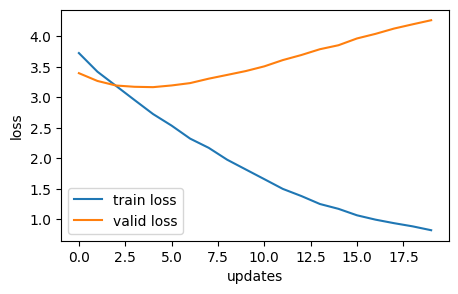

In [40]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [41]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.256 | Test PPL:  25.949 |


In [65]:
import pickle

In [66]:
# save the model
with open('models/transfmodelormer.pkl', 'wb') as f:
    pickle.dump(model, f)

In [67]:
# save vocab_transform
with open('models/vocab.pkl', 'wb') as f:
    pickle.dump(vocab_transform, f)

In [68]:
# save the tokenizer
with open('models/tokenizer.pkl', 'wb') as f:
    pickle.dump(token_transform, f)

In [163]:
import dill

In [168]:
with open('models/text_transform.dill', 'wb') as f:
    dill.dump(text_transform, f)

In [164]:
with open('models/train_loader.dill', 'wb') as f:
    dill.dump(train_loader, f)

In [165]:
with open('models/test_loader.dill', 'wb') as f:
    dill.dump(test_loader, f)

In [166]:
with open('models/val_loader.dill', 'wb') as f:
    dill.dump(valid_loader, f)

## 7. Test on some random news

In [42]:
sample[0]

'The time now is 05:08 .'

In [106]:
sample[1]

'The time now is 05:05 .'

In [44]:
src_text = text_transform[SRC_LANGUAGE](sample[0]).to(device)
src_text

tensor([  2,  23,  90, 145,  16,   0,   6,   3])

In [45]:
trg_text = text_transform[TRG_LANGUAGE](sample[1]).to(device)
trg_text

tensor([   2, 1138, 8025, 6426, 2691,    0,    6,    3])

In [46]:
src_text = src_text.reshape(1, -1)  #because batch_size is 1

In [47]:
trg_text = trg_text.reshape(1, -1)

In [48]:
src_text.shape, trg_text.shape

(torch.Size([1, 8]), torch.Size([1, 8]))

In [49]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [50]:
model.load_state_dict(torch.load(save_path))

model.eval()
with torch.no_grad():
    test_output, attentions = model(src_text, trg_text) #turn off teacher forcing

In [51]:
test_output.shape #batch_size, trg_len, trg_output_dim

torch.Size([1, 8, 15458])

Since batch size is 1, we just take off that dimension

In [52]:
test_output = test_output.squeeze(0)

In [53]:
test_output.shape

torch.Size([8, 15458])

We shall remove the first token since it's zeroes anyway

In [54]:
test_output = test_output[1:]
test_output.shape #trg_len, trg_output_dim

torch.Size([7, 15458])

Then we just take the top token with highest probabilities

In [55]:
output_max = test_output.argmax(1) #returns max indices

In [56]:
output_max

tensor([   0, 6426, 2691,    0,    6,    3,    0])

Get the mapping of the target language

In [57]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [58]:
for token in output_max:
    print(mapping[token.item()])

<unk>
now
is
<unk>
.
<eos>
<unk>


## 8. Attention

Let's display the attentions to understand how the source text links with the generated text

In [59]:
attentions.shape

torch.Size([1, 8, 8, 8])

Since there are 8 heads, we can look at just 1 head for sake of simplicity.

In [60]:
attention = attentions[0, 0, :, :]
attention.shape

torch.Size([8, 8])

In [61]:
test_tokens_sur = ['<sos>'] + token_transform[SRC_LANGUAGE](sample[0]) + ['<eos>']
test_tokens_sur

['<sos>', 'The', 'time', 'now', 'is', '05:08', '.', '<eos>']

In [62]:
test_trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
test_trg_tokens

['<sos>', '<unk>', 'now', 'is', '<unk>', '.', '<eos>', '<unk>']

In [96]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().tolist()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=10)
    
    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence 
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

C:\Users\surya\AppData\Local\Temp\ipykernel_11448\1777870314.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45)
C:\Users\surya\AppData\Local\Temp\ipykernel_11448\1777870314.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)


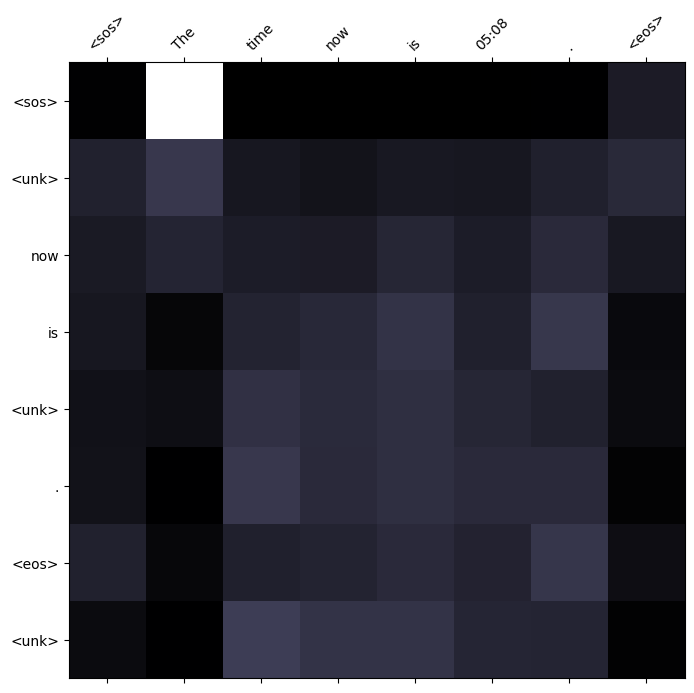

In [97]:
display_attention(test_tokens_sur, test_trg_tokens, attention)

In [135]:
def display_attention(sentence, translation, attention, attention_type):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().tolist()  # Move to CPU and convert to list for plotting
    
    cax = ax.matshow(attention, cmap='bone')  # Use heatmap to visualize attention matrix
    ax.tick_params(labelsize=10)
    
    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence 
    
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.set_title(f'Attention Mechanism: {attention_type}', fontsize=14)
    
    plt.show()
    plt.close()

In [ ]:
import torch
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

# Function to display attention
def display_attention(sentence, translation, attention, attention_type):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().tolist()  # Move to CPU and convert to list for plotting
    
    cax = ax.matshow(attention, cmap='bone')  # Use heatmap to visualize attention matrix
    ax.tick_params(labelsize=10)
    
    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence 
    
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.set_title(f'Attention Mechanism: {attention_type}', fontsize=14)
    
    plt.show()
    plt.close()

# Assuming the model has methods for each attention type:
def display_attention_for_all_mechanisms(src_text, trg_text, model, vocab_transform, token_transform):
    # Ensure src_text is a tensor of token indices or a list of tokens
    if isinstance(src_text, str):
        # If src_text is a string, tokenize it
        src_text = token_transform[SRC_LANGUAGE](src_text)
    
    # If src_text is already tokenized, it is already a list of tokens
    # Convert list of tokens to indices if it's not already a tensor of indices
    if isinstance(src_text, list):
        src_indices = [vocab_transform[SRC_LANGUAGE].stoi[token] for token in src_text]
    else:
        src_indices = src_text.tolist()  # If src_text is already a tensor, convert to list of indices
    
    src_tensor = torch.tensor(src_indices).unsqueeze(0)  # Add batch dimension
    
    # Ensure trg_text is a tensor of token indices
    if isinstance(trg_text, str):
        # If trg_text is a string, tokenize it
        trg_text = token_transform[TRG_LANGUAGE](trg_text)
    
    # Convert trg_text to tensor of indices using the vocabulary
    if isinstance(trg_text, list):
        trg_indices = [vocab_transform[TRG_LANGUAGE].stoi[token] for token in trg_text]
    else:
        trg_indices = trg_text.tolist()
        
    trg_tensor = torch.tensor(trg_indices).unsqueeze(0)  # Add batch dimension

    # Put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        test_output, attentions = model(src_tensor, trg_tensor)  # Turn off teacher forcing

    test_output = test_output[1:]
    output_max = test_output.argmax(1)
    
    # Get the mapping to convert indices to words
    mapping = vocab_transform[TRG_LANGUAGE].get_itos()
    
    # Prepare source and target tokens
    test_tokens_sur = ['<sos>'] + src_text + ['<eos>']
    test_trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
    
    # General Attention
    attention = attentions[0, 0, :, :]
    display_attention(test_tokens_sur, test_trg_tokens, attention, "General Attention")
    
    # Multiplicative Attention (Assuming the model computes multiplicative attention)
    attention = attentions[1, 0, :, :]
    display_attention(test_tokens_sur, test_trg_tokens, attention, "Multiplicative Attention")
    
    # Additive Attention (Assuming the model computes additive attention)
    attention = attentions[2, 0, :, :]
    display_attention(test_tokens_sur, test_trg_tokens, attention, "Additive Attention")

# Example usage (assuming src_text, trg_text, model, vocab_transform, and token_transform are defined)
# Display attention for all types
display_attention_for_all_mechanisms(src_text, trg_text, model, vocab_transform, token_transform)


In [148]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Function to compute general attention scores
def general_attention(decoder_hidden, encoder_outputs):
    # e_i = s^T h_i
    attention_scores = torch.bmm(encoder_outputs, decoder_hidden.unsqueeze(2)).squeeze(2)
    return attention_scores

# Function to compute multiplicative attention scores
def multiplicative_attention(decoder_hidden, encoder_outputs, W):
    # e_i = s^T W h_i
    decoder_hidden = decoder_hidden.unsqueeze(1)
    attention_scores = torch.bmm(encoder_outputs, W @ decoder_hidden.transpose(1, 2)).squeeze(2)
    return attention_scores

# Function to compute additive attention scores
def additive_attention(decoder_hidden, encoder_outputs, W1, W2, v):
    # e_i = v^T tanh(W1 h_i + W2 s)
    hidden_combined = torch.tanh(W1 @ encoder_outputs + W2 @ decoder_hidden)
    attention_scores = torch.matmul(hidden_combined, v)
    return attention_scores

# Function to visualize attention
def display_attention(sentence, translation, attention, attention_type):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(1).cpu().detach().tolist()  # Move to CPU and convert to list for plotting
    cax = ax.matshow(attention, cmap='bone')  # Use heatmap to visualize attention matrix

    ax.tick_params(labelsize=10)

    y_ticks = [''] + translation
    x_ticks = [''] + sentence

    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.set_title(f'Attention Mechanism: {attention_type}', fontsize=14)

    plt.show()
    plt.close()

# Example: Using the attention functions
def display_attention_for_all_mechanisms(src_text, trg_text, model, vocab_transform, token_transform, W, W1, W2, v):
    # Ensure src_text is a tensor of token indices or a list of tokens
    if isinstance(src_text, str):
        # If src_text is a string, tokenize it
        src_text = token_transform[SRC_LANGUAGE](src_text)

    # If src_text is already tokenized, it is already a list of tokens
    # Convert list of tokens to indices if it's not already a tensor of indices
    if isinstance(src_text, list):
        src_indices = [vocab_transform[SRC_LANGUAGE].get_stoi()[token] for token in src_text]
    else:
        src_indices = src_text.tolist()  # If src_text is already a tensor, convert to list of indices
    
    src_tensor = torch.tensor(src_indices).unsqueeze(0)  # Add batch dimension

    # Ensure trg_text is a tensor of token indices
    if isinstance(trg_text, str):
        # If trg_text is a string, tokenize it
        trg_text = token_transform[TRG_LANGUAGE](trg_text)

    # Convert trg_text to tensor of indices using the vocabulary
    if isinstance(trg_text, list):
        trg_indices = [vocab_transform[TRG_LANGUAGE].get_stoi()[token] for token in trg_text]
    else:
        trg_indices = trg_text.tolist()
        
    trg_tensor = torch.tensor(trg_indices).unsqueeze(0)  # Add batch dimension

    # Put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        test_output, attentions = model(src_tensor, trg_tensor)  # Turn off teacher forcing

    test_output = test_output[1:]
    output_max = test_output.argmax(1)

    # Get the mapping to convert indices to words
    mapping = vocab_transform[TRG_LANGUAGE].get_itos()

    # Prepare source and target tokens
    test_tokens_sur = ['<sos>'] + src_text + ['<eos>']
    test_trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]

    # General Attention
    attention = general_attention(trg_tensor, src_tensor)
    display_attention(test_tokens_sur, test_trg_tokens, attention, "General Attention")

    # Multiplicative Attention
    attention = multiplicative_attention(trg_tensor, src_tensor, W)
    display_attention(test_tokens_sur, test_trg_tokens, attention, "Multiplicative Attention")

    # Additive Attention
    attention = additive_attention(trg_tensor, src_tensor, W1, W2, v)
    display_attention(test_tokens_sur, test_trg_tokens, attention, "Additive Attention")


In [158]:
import torch

# Function to compute general attention scores
def general_attention(decoder_hidden, encoder_outputs):
    # Ensure decoder_hidden has the shape [batch_size, 1, hidden_dim]
    decoder_hidden = decoder_hidden.unsqueeze(1)  # Add an extra dimension for sequence length

    # Ensure encoder_outputs has the shape [batch_size, seq_len, hidden_dim]
    if encoder_outputs.dim() == 2:
        # If encoder_outputs is 2D, we need to reshape it to [batch_size, seq_len, hidden_dim]
        encoder_outputs = encoder_outputs.unsqueeze(1)  # Add a dummy seq_len dimension if needed

    # Perform batch matrix multiplication (bmm) to calculate attention scores
    attention_scores = torch.bmm(encoder_outputs, decoder_hidden.transpose(1, 2)).squeeze(2)

    return attention_scores

# Example: Using the attention functions
def display_attention_for_all_mechanisms(src_text, trg_text, model, vocab_transform, token_transform, W, W1, W2, v):
    # Ensure src_text is a tensor of token indices or a list of tokens
    if isinstance(src_text, str):
        # If src_text is a string, tokenize it
        src_text = token_transform[SRC_LANGUAGE](src_text)

    # If src_text is already tokenized, it is already a list of tokens
    # Convert list of tokens to indices if it's not already a tensor of indices
    if isinstance(src_text, list):
        src_indices = [vocab_transform[SRC_LANGUAGE].get_stoi()[token] for token in src_text]
    else:
        src_indices = src_text.tolist()  # If src_text is already a tensor, convert to list of indices
    
    src_tensor = torch.tensor(src_indices).unsqueeze(0)  # Add batch dimension

    # Ensure trg_text is a tensor of token indices
    if isinstance(trg_text, str):
        # If trg_text is a string, tokenize it
        trg_text = token_transform[TRG_LANGUAGE](trg_text)

    # Convert trg_text to tensor of indices using the vocabulary
    if isinstance(trg_text, list):
        trg_indices = [vocab_transform[TRG_LANGUAGE].get_stoi()[token] for token in trg_text]
    else:
        trg_indices = trg_text.tolist()
        
    trg_tensor = torch.tensor(trg_indices).unsqueeze(0)  # Add batch dimension

    # Put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        test_output, attentions = model(src_tensor, trg_tensor)  # Turn off teacher forcing

    test_output = test_output[1:]
    output_max = test_output.argmax(1)

    # Get the mapping to convert indices to words
    mapping = vocab_transform[TRG_LANGUAGE].get_itos()

    # Prepare source and target tokens
    test_tokens_sur = ['<sos>'] + src_text + ['<eos>']
    test_trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]

    # General Attention
    attention = general_attention(trg_tensor, src_tensor)
    display_attention(test_tokens_sur, test_trg_tokens, attention, "General Attention")

    # Multiplicative Attention
    attention = multiplicative_attention(trg_tensor, src_tensor, W)
    display_attention(test_tokens_sur, test_trg_tokens, attention, "Multiplicative Attention")

    # Additive Attention
    attention = additive_attention(trg_tensor, src_tensor, W1, W2, v)
    display_attention(test_tokens_sur, test_trg_tokens, attention, "Additive Attention")


In [159]:
# Example of defining a hidden_dim in your attention code
hidden_dim = 512  # Example hidden dimension

# Example of using hidden_dim for weight matrices in attention
W = torch.rand(hidden_dim, hidden_dim)  # For multiplicative attention
W1 = torch.rand(hidden_dim, hidden_dim)  # For additive attention
W2 = torch.rand(hidden_dim, hidden_dim)  # For additive attention
v = torch.rand(hidden_dim)  # For additive attention


In [160]:
model.eval()  # Set the model to evaluation mode

# Call the function to display all types of attention
display_attention_for_all_mechanisms(src_text, trg_text, model, vocab_transform, token_transform, W, W1, W2, v)

RuntimeError: Expected batch2_sizes[0] == bs && batch2_sizes[1] == contraction_size to be true, but got false.  (Could this error message be improved?  If so, please report an enhancement request to PyTorch.)

In [ ]:
# Load the tokenizer
with open('./models/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

In [116]:
# Load the vocab
with open('./models/vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

In [128]:
# load the model
with open('./models/transfmodelormer.pkl', 'rb') as f:
    model_test = pickle.load(f)

In [129]:
vocab

{'en': Vocab(), 'fr': Vocab()}

In [130]:
tokenizer

{'en': functools.partial(<function _spacy_tokenize at 0x000001F2B744AE50>, spacy=<spacy.lang.en.English object at 0x000001F28071CCA0>),
 'fr': functools.partial(<function _spacy_tokenize at 0x000001F2B744AE50>, spacy=<spacy.lang.fr.French object at 0x000001F3008D1FD0>)}

In [132]:
def translate_sentence(sentence, model_imp, tokenizer, vocab, src_lang='en', trg_lang='fr', max_length=1000):
    # Step 1: Tokenize the sentence using the source language tokenizer
    test_tokenized_src = tokenizer[src_lang](sentence)
    
    # Step 2: Convert the tokens to indices using the source language vocab
    test_src_indices = [vocab[src_lang].get_stoi()[token] for token in test_tokenized_src]
    
    # Step 3: Convert indices to a tensor and move it to the correct device
    test_src_tensor = torch.tensor(test_src_indices).unsqueeze(0).to(device)  # Add batch dimension

    model_imp.eval()
    # Step 4: Perform inference (translation) with the model
    with torch.no_grad():
        test_output = model_imp(test_src_tensor)  # Assuming model returns a tensor of shape (batch_size, seq_len, vocab_size)

    # Step 5: Get the predicted token indices from the model output (e.g., by taking the argmax)
    test_predicted_tokens = test_output.argmax(dim=-1)  # (batch_size, seq_len)

    # Step 6: Convert token indices to words using the target language vocab
    test_trg_tokens = [vocab[trg_lang].itos[idx.item()] for idx in test_predicted_tokens[0]]  # Convert each token

    # Step 7: Join the target tokens to form the translated sentence
    test_translated_sentence = " ".join(test_trg_tokens)

    return test_translated_sentence


# Example usage:
test_src_sentence = "This is a test sentence."
test_translated = translate_sentence(test_src_sentence, model_test, tokenizer, vocab)
print(f"Translated Sentence: {test_translated}")


TypeError: forward() missing 1 required positional argument: 'trg'